In [ ]:
!pip install -q scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,
ConfusionMatrixDisplay, precision_recall_fscore_support

In [ ]:
train_df = pd.read_csv("/content/train.txt", sep=';', header=None, names=["text", "label"])
val_df   = pd.read_csv("/content/val.txt", sep=';', header=None, names=["text", "label"])
test_df  = pd.read_csv("/content/test.txt", sep=';', header=None, names=["text", "label"])

 Exploratory Data Analysis (EDA)

In [ ]:
display(train_df)

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [ ]:
print("Labels:", train_df['label'].unique())

Labels: ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


In [ ]:
label_counts = train_df['label'].value_counts()

df_label_counts = label_counts.reset_index()
df_label_counts.columns = ['label', 'count']

display(df_label_counts)

print(f"\nName: count, dtype: {label_counts.dtype}")

,label,count
0,joy,5362
1,sadness,4666
2,anger,2159
3,fear,1937
4,love,1304
5,surprise,572



Name: count, dtype: int64


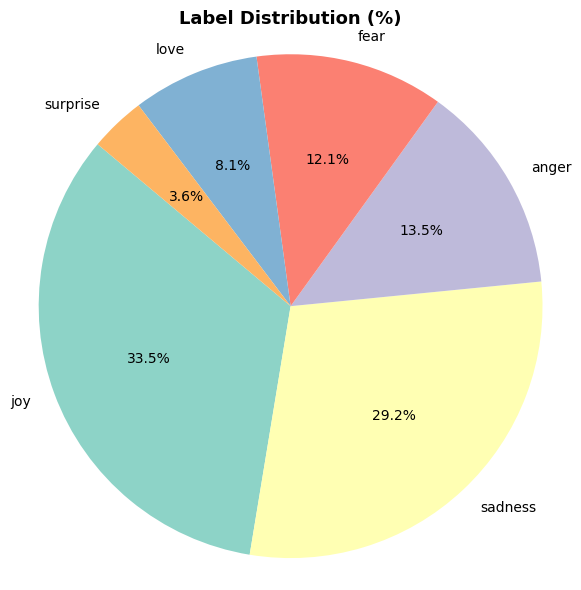

In [ ]:
import matplotlib.pyplot as plt

label_percentage = train_df['label'].value_counts(normalize=True) * 100

colors = plt.cm.Set3.colors

plt.figure(figsize=(6, 6))
plt.pie(
    label_percentage,
    labels=label_percentage.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 10}
)
plt.title("Label Distribution (%)", fontsize=13, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
train_df["word_count"] = train_df["text"].apply(lambda x: len(str(x).split()))

print("Longest sentence:")
print(train_df.loc[train_df['word_count'].idxmax(), 'text'])

print("\nShortest sentence:")
print(train_df.loc[train_df['word_count'].idxmin(), 'text'])

Longest sentence:
i guess which meant or so i assume no photos no words or no other way to convey what it really feels unless you feels it yourself or khi bi t au th m i bi t th ng ng i b au i rephrase it to a bit more gloomy context unless you are hurt yourself you will never have sympathy for the hurt ones

Shortest sentence:
earth crake


In [ ]:
avg_words_per_label = train_df.groupby("label")["word_count"].mean().sort_values(ascending=False)

df_avg_words = avg_words_per_label.reset_index()
df_avg_words.columns = ['label', 'avg_word_count']

display(df_avg_words)

print(f"\nName: avg_word_count, dtype: {avg_words_per_label.dtype}")

,label,avg_word_count
0,love,20.700153
1,surprise,19.970280
2,joy,19.498135
3,anger,19.229736
4,fear,18.844605
5,sadness,18.361980



Name: avg_word_count, dtype: float64


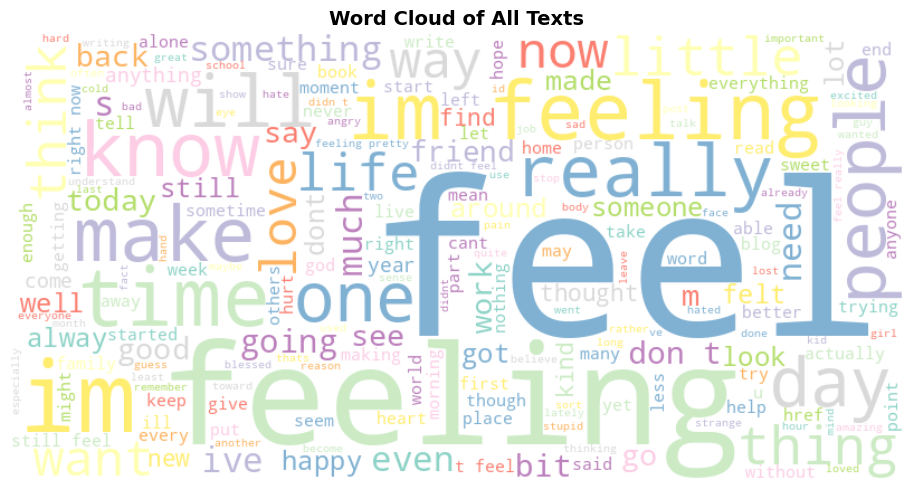

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

text_all = " ".join(train_df["text"])

set3_colors = plt.cm.Set3.colors
colormap = ListedColormap(set3_colors)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap=colormap
).generate(text_all)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Texts", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

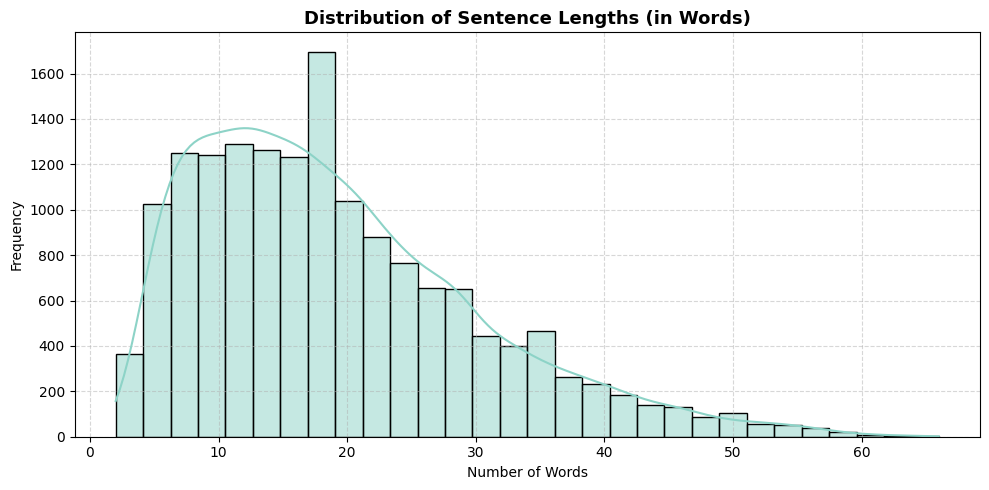

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

hist_color = plt.cm.Set3(0)

plt.figure(figsize=(10, 5))
sns.histplot(train_df["word_count"], bins=30, kde=True, color=hist_color, edgecolor="black")
plt.title("Distribution of Sentence Lengths (in Words)", fontweight='bold', fontsize=13)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

 Model Training & Evaluation

In [ ]:
le = LabelEncoder()
train_df["label_enc"] = le.fit_transform(train_df["label"])
val_df["label_enc"] = le.transform(val_df["label"])
test_df["label_enc"] = le.transform(test_df["label"])

X_train, y_train = train_df["text"], train_df["label_enc"]
X_val, y_val = val_df["text"], val_df["label_enc"]
X_test, y_test = test_df["text"], test_df["label_enc"]

pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000))
])


pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

       anger       0.91      0.81      0.86       275
        fear       0.86      0.73      0.79       212
         joy       0.84      0.95      0.89       704
        love       0.88      0.62      0.73       178
     sadness       0.86      0.94      0.90       550
    surprise       0.85      0.58      0.69        81

    accuracy                           0.86      2000
   macro avg       0.87      0.77      0.81      2000
weighted avg       0.86      0.86      0.85      2000



Confusion Matrix

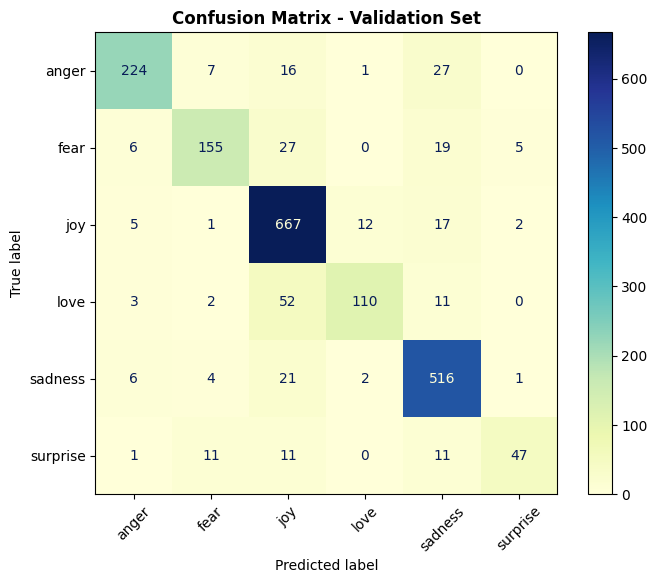

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="YlGnBu", xticks_rotation=45)
plt.title("Confusion Matrix - Validation Set", fontweight='bold')
plt.grid(False)
plt.show()

Hyperparameter Tuning with GridSearchCV

In [ ]:
params = {
    "tfidf__max_df": [0.75, 0.85, 1.0],
    "clf__C": [0.1, 1, 10]
}

grid = GridSearchCV(pipe, params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Score (Validation Accuracy):", grid.best_score_)
print("Best Parameters:", grid.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Score (Validation Accuracy): 0.8723747451126082
Best Parameters: {'clf__C': 10, 'tfidf__max_df': 0.75}


In [ ]:
best_model = grid.best_estimator_

y_val_pred_best = best_model.predict(X_val)

print(classification_report(y_val, y_val_pred_best, target_names=le.classes_))

              precision    recall  f1-score   support

       anger       0.91      0.88      0.90       275
        fear       0.87      0.79      0.83       212
         joy       0.91      0.94      0.92       704
        love       0.87      0.79      0.83       178
     sadness       0.89      0.93      0.91       550
    surprise       0.81      0.74      0.77        81

    accuracy                           0.89      2000
   macro avg       0.88      0.85      0.86      2000
weighted avg       0.89      0.89      0.89      2000



In [ ]:
y_test_pred = best_model.predict(X_test)

print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

Test Set Evaluation:
              precision    recall  f1-score   support

       anger       0.89      0.86      0.88       275
        fear       0.86      0.82      0.84       224
         joy       0.88      0.94      0.91       695
        love       0.80      0.73      0.76       159
     sadness       0.92      0.92      0.92       581
    surprise       0.77      0.62      0.69        66

    accuracy                           0.88      2000
   macro avg       0.85      0.82      0.83      2000
weighted avg       0.88      0.88      0.88      2000



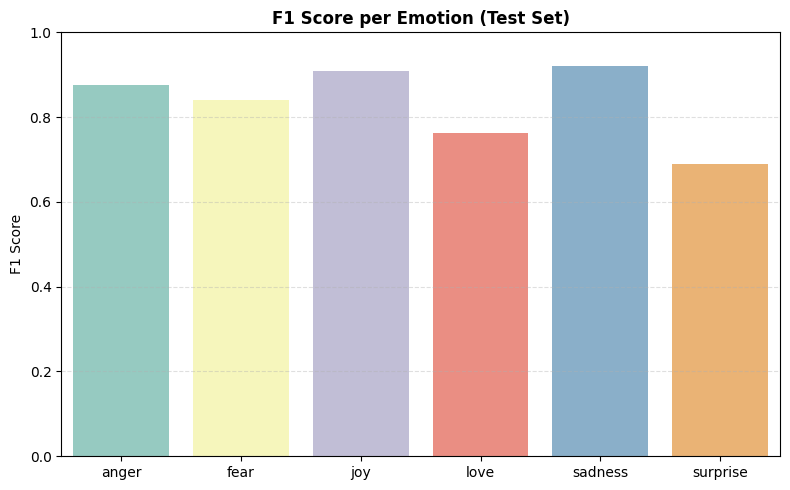

In [ ]:
f1_scores = precision_recall_fscore_support(y_test, y_test_pred, average=None)[2]

plt.figure(figsize=(8, 5))
sns.barplot(x=le.classes_, y=f1_scores, palette=plt.cm.Set3.colors)
plt.title("F1 Score per Emotion (Test Set)", fontweight='bold')
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
best_model = grid.best_estimator_
y_test_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

              precision    recall  f1-score   support

       anger       0.89      0.86      0.88       275
        fear       0.86      0.82      0.84       224
         joy       0.88      0.94      0.91       695
        love       0.80      0.73      0.76       159
     sadness       0.92      0.92      0.92       581
    surprise       0.77      0.62      0.69        66

    accuracy                           0.88      2000
   macro avg       0.85      0.82      0.83      2000
weighted avg       0.88      0.88      0.88      2000



In [ ]:
import joblib

joblib.dump(best_model, "emotion_model.pkl")

['emotion_model.pkl']

In [ ]:
from IPython.display import FileLink

FileLink("emotion_model.pkl")

/content/emotion_model.pkl

In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib

le = LabelEncoder()
train_df = pd.read_csv("/content/train.txt", sep=";", header=None, names=["text", "label"])
le.fit(train_df["label"])

joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [ ]:
from IPython.display import FileLink

FileLink("label_encoder.pkl")

/content/label_encoder.pkl